In [2]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
# import librosa

In [3]:
samplerate, data = wavfile.read('data/train/audio/yes/00f0204f_nohash_0.wav')

In [4]:
y = np.array([])
X = np.array([[]])
main_classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
train_set_path = "data\\train\\audio"
for class_dir in os.listdir(train_set_path):
    class_train_path = os.path.join(train_set_path, class_dir)
    pred_class = None
    if class_dir in main_classes:
        pred_class = class_dir
    else:
        pred_class = "unknown"
    for wav_file in tqdm(os.listdir(class_train_path), f"Processing {class_dir}"):
        samplerate, data = wavfile.read(os.path.join(class_train_path, wav_file))
        if X.shape[1] == 0:
            X = np.expand_dims(data, axis=1).T
        else:
            X = np.concatenate((X, np.expand_dims(data, axis=1).T), axis=0)
        y = np.concatenate((y, np.array([pred_class])))
    break

Processing bed:   0%|          | 0/1713 [00:00<?, ?it/s]

Processing down:  57%|█████▋    | 1342/2359 [00:02<00:01, 597.99it/s]


KeyboardInterrupt: 

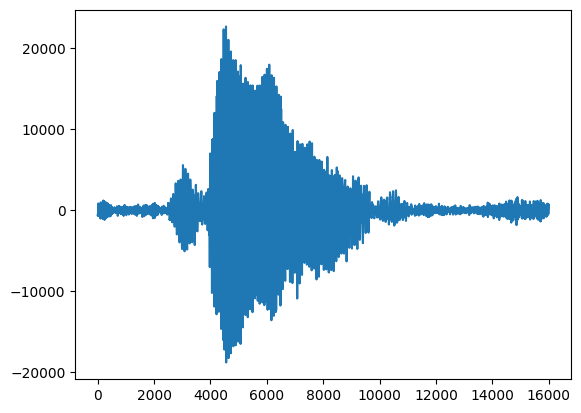

In [5]:
plt.plot(np.linspace(1, data.shape[0], data.shape[0]), data)